In [1]:
import os, shutil, copy, ntpath, datetime
import keras
from keras import models, layers, callbacks
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from keras.applications import VGG16

import matplotlib.pyplot as plt

import boto3
import glob
import ntpath
import re
import time

import numpy as np
import pandas as pd

Using TensorFlow backend.


# Settings

In [2]:
IMAGE_SHAPE=(150, 150, 3)

LIMIT_BATCHES = 593
#LIMIT_BATCHES = None

NUM_EPOCHS = 10
BATCH_SIZE = 20
NUM_CLASSES = 29

# PRETRAIN_MODEL = 'conv_base_local'
PRETRAIN_MODEL = 'conv_base_vgg16'
# PRETRAIN_MODEL = None

# Filesystem

In [3]:
#### FilePath Information
#DATA_DIR = '../data'
#ASL_ALPHABET_DATASET = os.path.join(DATA_DIR, 'asl_alphabet/processed_original_test')


# SAVED_MODEL_DIR = os.path.join(DATA_DIR, 'models/asl_alphabet')

In [4]:
#### FilePath Information
DATA_DIR = '../data'

LOCAL_DATASET_DIR = os.path.join(DATA_DIR, 'asl_alphabet')

TRAIN_DATASET_NAME = 'processed_asl_train'
LOCAL_TRAIN_DIR = os.path.join(LOCAL_DATASET_DIR, TRAIN_DATASET_NAME)

#NEW_TRAIN_DIR = '/tmp/asl_alphabet_train'
#NEW_TEST_DIR = '/tmp/asl_alphabet_test'

#FABRICATED_DIRS = [
#    NEW_TRAIN_DIR,
#    NEW_TEST_DIR
#]

SAVED_MODEL_DIR = os.path.join(DATA_DIR, 'models/asl_alphabet')

In [5]:
AVAILABLE_DATASETS = os.listdir(LOCAL_DATASET_DIR)
print(AVAILABLE_DATASETS)

['processed_inverted_rgb_ahe_test', 'processed_ahe_asl_test', 'processed_rgb_ahe_test', 'processed_asl_train', 'processed_grayscale_test', 'processed_ahe_inverted_asl_test', 'processed_original_test']


In [6]:
if not TRAIN_DATASET_NAME in AVAILABLE_DATASETS:
  raise Exception('we are expecting to see {} as one of the available datasets'.format(TRAIN_DATASET_NAME))
TEST_DATASET_NAMES = [dataset for dataset in AVAILABLE_DATASETS if dataset != TRAIN_DATASET_NAME]
print('We have one training set and {} test sets'.format(len(TEST_DATASET_NAMES)))
LOCAL_TEST_DIRS = [os.path.join(LOCAL_DATASET_DIR, name) for name in TEST_DATASET_NAMES]

We have one training set and 6 test sets


In [7]:
def get_sign_folders(from_folder):
  # https://stackoverflow.com/questions/973473/getting-a-list-of-all-subdirectories-in-the-current-directory
  folders = next(os.walk(from_folder))[1]
  return folders

In [8]:
# A, B, C, D, DELETE, etc
ASL_FOLDERS = get_sign_folders(LOCAL_TRAIN_DIR)

In [9]:
training_length = len(os.listdir(os.path.join(LOCAL_TRAIN_DIR, 'A')))
testing_length = len(os.listdir(os.path.join(LOCAL_TEST_DIRS[0], 'A')))

num_classes = len(os.listdir(LOCAL_TRAIN_DIR))

print('{} images in training dir; and {} images in testing dir for a single class, with a total of {} classes'.format(training_length, testing_length, num_classes))

17100 images in training dir; and 150 images in testing dir for a single class, with a total of 30 classes


# Check GPU

In [10]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Create Data Generators

In [11]:
def create_test_datagen(directory):
  test_datagen = ImageDataGenerator(rescale=1./255)
  return test_datagen.flow_from_directory(
         directory,
         target_size = (IMAGE_SHAPE[0], IMAGE_SHAPE[0]),
         batch_size = BATCH_SIZE,
         color_mode = "rgb",
         class_mode='categorical'
  )

In [12]:
# dataset definition with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    )

In [13]:
#create generators
train_generator = train_datagen.flow_from_directory(
           LOCAL_TRAIN_DIR,
           target_size = (IMAGE_SHAPE[0], IMAGE_SHAPE[0]),
           batch_size=BATCH_SIZE,
           class_mode = 'categorical',
           subset='training'
)

#create generators
validation_generator = train_datagen.flow_from_directory(
           LOCAL_TRAIN_DIR,
           target_size = (IMAGE_SHAPE[0], IMAGE_SHAPE[0]),
           batch_size=BATCH_SIZE,
           class_mode = 'categorical',
           subset='validation'
)

test_generators = [create_test_datagen(dir) for dir in LOCAL_TEST_DIRS]

Found 446310 images belonging to 29 classes.
Found 49590 images belonging to 29 classes.
Found 4350 images belonging to 29 classes.
Found 4350 images belonging to 29 classes.
Found 4350 images belonging to 29 classes.
Found 4350 images belonging to 29 classes.
Found 4350 images belonging to 29 classes.
Found 4350 images belonging to 29 classes.


# Models

In [14]:
def create_vgg_model():
    conv_base = VGG16(weights='imagenet',
                      include_top=False,
                      input_shape=(IMAGE_SHAPE[0], IMAGE_SHAPE[1], IMAGE_SHAPE[2]))
    print(conv_base.summary())
    
    conv_base.trainable = False
    
    model = models.Sequential()
    model.add(conv_base)
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(29, activation='sigmoid'))

    optimizer = keras.optimizers.RMSprop(lr=0.0001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    model.summary()
    return model
    
    

In [15]:
def create_blank_model():
    model = models.Sequential()
    model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=IMAGE_SHAPE))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(256, (3, 3), activation='relu'))

    #Add a classfier on top of the convnet
    model.add(layers.Flatten())
    model.add(layers.Dropout(.5))
    model.add(layers.Dense(128, activation='relu'))
    #model.add(layers.BatchNormalization())
    model.add(layers.Dense(NUM_CLASSES, activation='softmax'))

    #compile the model
    optimizer = keras.optimizers.RMSprop(lr=0.0001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    print(model.summary())
    return model


In [16]:
if not PRETRAIN_MODEL:
    model = create_blank_model()
elif PRETRAIN_MODEL == 'conv_base_vgg16':
    model = create_vgg_model()

58892288/58889256 [==============================] - 4s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool

In [17]:
steps_per_epoch = None

if LIMIT_BATCHES is None:
  steps_per_epoch_train = len(train_generator)
  steps_per_epoch_val = len(train_generator)
  steps_per_epoch_test = len(test_generators[0])
else:
  steps_per_epoch_train = LIMIT_BATCHES
  steps_per_epoch_val = LIMIT_BATCHES
  steps_per_epoch_test = LIMIT_BATCHES
  

history= model.fit_generator (
           train_generator,
           epochs = NUM_EPOCHS,
           steps_per_epoch=steps_per_epoch_train,
           validation_steps=steps_per_epoch_val,
           #callbacks = callbacks_list,
           validation_data=validation_generator,
           verbose=1)

Epoch 1/10
593/593 [==============================] - 162s 272ms/step - loss: 2.5891 - acc: 0.3218 - val_loss: 2.2056 - val_acc: 0.3885
Epoch 2/10
593/593 [==============================] - 155s 262ms/step - loss: 1.6565 - acc: 0.5584 - val_loss: 1.7445 - val_acc: 0.5088
Epoch 3/10
593/593 [==============================] - 155s 261ms/step - loss: 1.3062 - acc: 0.6417 - val_loss: 1.5394 - val_acc: 0.5635
Epoch 4/10
593/593 [==============================] - 155s 261ms/step - loss: 1.1463 - acc: 0.6805 - val_loss: 1.3899 - val_acc: 0.6019
Epoch 5/10
593/593 [==============================] - 157s 265ms/step - loss: 1.0251 - acc: 0.7059 - val_loss: 1.3209 - val_acc: 0.6256
Epoch 6/10
593/593 [==============================] - 156s 263ms/step - loss: 0.9223 - acc: 0.7283 - val_loss: 1.2507 - val_acc: 0.6287
Epoch 7/10
593/593 [==============================] - 156s 263ms/step - loss: 0.8793 - acc: 0.7424 - val_loss: 1.1938 - val_acc: 0.6378
Epoch 8/10
593/593 [============================

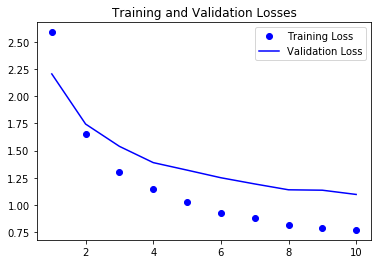

In [18]:
#visualization of model performance
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values =  history_dict['val_loss']
acc_values = history_dict['acc']

epochs = range(1, len(acc_values) + 1)

plt.plot(epochs, loss_values, 'bo', label = 'Training Loss')
plt.plot(epochs,val_loss_values, 'b', label = 'Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel='Epochs'
plt.ylabel='Loss'
plt.legend()
plt.show()

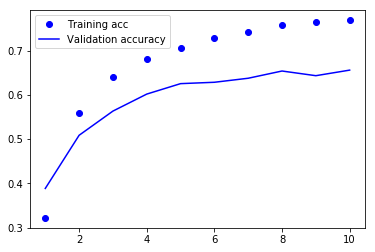

In [19]:
plt.clf()
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs,val_acc_values, 'b', label='Validation accuracy')
plt.xlabel = 'Epochs'
plt.ylabel = 'Loss'
plt.legend()

plt.show()

## Validate against each of the test generators

In [20]:
def get_test_accuracy():
    accuracies = []
    for generator, _dir in zip(test_generators, LOCAL_TEST_DIRS):
      test_loss, test_acc = model.evaluate_generator(generator, steps=steps_per_epoch_test)
      accuracies.append(test_acc)
      print('{}: {}'.format(_dir, test_acc))
    return np.average(accuracies)

## Save things

In [21]:
test_accuracy = get_test_accuracy()

../data/asl_alphabet/processed_inverted_rgb_ahe_test: 0.8247466226787986
../data/asl_alphabet/processed_ahe_asl_test: 0.8770270264027892
../data/asl_alphabet/processed_rgb_ahe_test: 0.8446790545776084
../data/asl_alphabet/processed_grayscale_test: 0.8343750013894325
../data/asl_alphabet/processed_ahe_inverted_asl_test: 0.8502533782172847
../data/asl_alphabet/processed_original_test: 0.8773648616027188


In [22]:
def ensure_model_directory_exists():
    try:
        os.makedirs(SAVED_MODEL_DIR)
    except:
        print('Tried to create "{}" but it already exists'.format(SAVED_MODEL_DIR))

def save_model():
    ensure_model_directory_exists()
    
    timestamp_raw = str(datetime.datetime.now())
    timestamp_without_milliseconds = timestamp_raw.split('.')[0]
    
    model_filename = '{}___{}.h5'.format(timestamp_without_milliseconds, test_accuracy)
    model_filepath = os.path.join(SAVED_MODEL_DIR, model_filename)
    
    print('saving file {}'.format(model_filepath))

    model.save(model_filepath)
save_model()

Tried to create "../data/models/asl_alphabet" but it already exists
saving file ../data/models/asl_alphabet/2019-01-12 17:21:35___0.8514076574781054.h5


In [23]:
# Send text message when complete (if the environment variable "TEXT_PHONENUMBER" is set)
if 'TEXT_PHONENUMBER' in os.environ:
    text_phonenumber = os.environ['TEXT_PHONENUMBER']
    client = boto3.client('sns')
    client.publish(PhoneNumber=text_phonenumber, Message='Model Finished with mae {}'.format(test_accuracy))
    print('text sent')

text sent


In [24]:
from IPython.display import Javascript

script = '''
require(["base/js/namespace"],function(Jupyter) {
    Jupyter.notebook.save_checkpoint();
});
'''

def notebook_save():
    Javascript(script)
    
    print('This notebook has been saved')
notebook_save()

This notebook has been saved


In [25]:
def turn_off_instance():
    if 'INSTANCE_ID' in os.environ:
        client = boto3.client('ec2')
        client.stop_instances(InstanceIds=[os.environ['INSTANCE_ID']])

# Find Largest Errors

In [26]:
from keras.models import load_model

In [27]:
# optionally load a previous model to review (will overwrite the global "model" variable)
# model = load_model('../data/models/asl_alphabet/2018-12-07 04:36:16___0.9285714030265808.h5')

In [28]:
validation_generator.class_indices
class_name_by_index = {}
for index, class_name in enumerate(validation_generator.class_indices):
    class_name_by_index[int(index)] = class_name

In [29]:
NUMBER_OF_VALIDATION_IMAGES = 8698

In [30]:
images = []
class_vectors = []

while len(images) < NUMBER_OF_VALIDATION_IMAGES:
    _images, _class_vectors = next(validation_generator)
    if len(images) == 0:
        images = _images
        class_vectors = _class_vectors
    else:
        images = np.append(images, _images, axis=0)
        class_vectors = np.append(class_vectors, _class_vectors, axis=0)

In [31]:
c = None
true_classes = []
predicted_classes = []
selected_probabilities = []
true_probabilities = []
dissonance = []

predictions = model.predict(images)
#_probability = model.predict_proba(images)

for class_vector, probability in zip(class_vectors, predictions):
    predicted_class = probability.argmax(axis=-1)
    true_class = class_vector.argmax(axis=-1)
    selected_probability = probability.max()
    true_probability = probability[true_class]

    true_classes.append(true_class)
    predicted_classes.append(predicted_class)
    selected_probabilities.append(selected_probability)
    true_probabilities.append(true_probability)
    dissonance.append(selected_probability - true_probability)

validations = pd.DataFrame({
    'true_class': true_classes,
    'selected_class': predicted_classes,
    'true_class_name': [class_name_by_index[_class] for _class in true_classes],
    'selected_class_name': [class_name_by_index[_class] for _class in predicted_classes],
    'selected_probability': selected_probabilities,
    'true_probabilities': true_probabilities,
    'dissonance': dissonance
})

errors = validations[validations['selected_class'] != validations['true_class']].sort_values('dissonance')
errors

,dissonance,selected_class,selected_class_name,selected_probability,true_class,true_class_name,true_probabilities
8601,1.320223e-08,1,L,0.000040,14,N,0.000040
1411,3.107743e-08,22,F,0.000009,17,H,0.000009
4580,6.641585e-08,22,F,0.000008,4,J,0.000008
4830,7.295512e-08,21,Q,0.000006,28,nothing,0.000006
7447,9.534142e-08,21,Q,0.000009,18,M,0.000009
6750,1.206299e-07,22,F,0.000028,17,H,0.000028
2569,1.211592e-07,21,Q,0.000008,20,A,0.000008
4240,1.257731e-07,21,Q,0.000009,10,space,0.000008
7449,1.356675e-07,11,U,0.000148,3,I,0.000148
727,1.792068e-07,19,Z,0.000103,24,V,0.000103


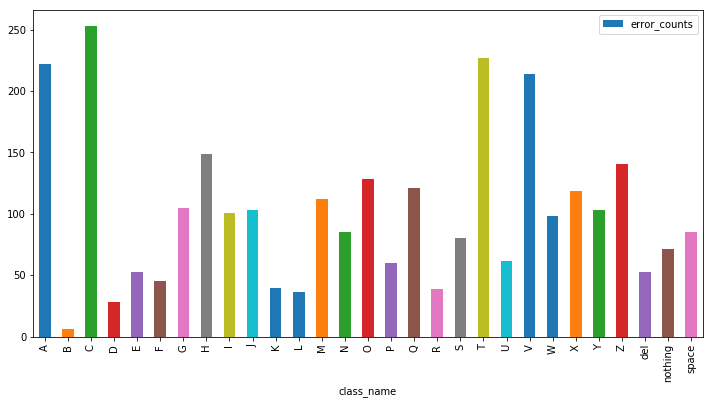

In [32]:
# Count how many errors are in each class
errors_counts = errors.groupby('true_class_name') \
    .size() \
    .reset_index(name='counts')
errors_counts.columns = ['class_name', 'error_counts']

errors_counts.plot.bar(x='class_name', y='error_counts', figsize=(12, 6))

In [33]:
total_counts = validations.groupby(['true_class_name']) \
    .size() \
    .reset_index(name='counts')
total_counts.columns = ['class_name', 'total_counts']

In [34]:
counts_pd = total_counts.merge(errors_counts, on='class_name')
counts_pd

,class_name,total_counts,error_counts
0,A,278,222
1,B,295,6
2,C,301,253
3,D,289,28
4,E,309,53
5,F,313,45
6,G,304,105
7,H,295,149
8,I,300,101
9,J,317,103


In [35]:
counts_pd['percent_errors'] = counts_pd.error_counts / counts_pd.total_counts

In [36]:
counts_pd

,class_name,total_counts,error_counts,percent_errors
0,A,278,222,0.798561
1,B,295,6,0.020339
2,C,301,253,0.840532
3,D,289,28,0.096886
4,E,309,53,0.171521
5,F,313,45,0.143770
6,G,304,105,0.345395
7,H,295,149,0.505085
8,I,300,101,0.336667
9,J,317,103,0.324921


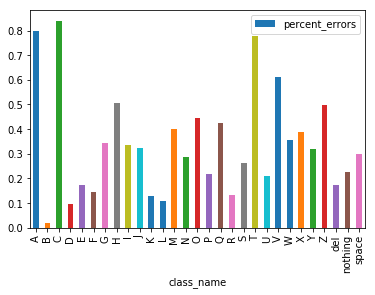

In [37]:
counts_pd.plot.bar(x='class_name', y='percent_errors')

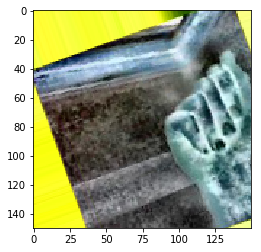

In [38]:
plt.imshow(images[93])